In [1]:
! pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    auc,
    roc_curve,
    confusion_matrix,
    classification_report,
)

In [3]:
import yfinance as yf

xmr = yf.Ticker("XMR-USD")
df_xmr = yf.download(tickers="XMR-USD", period="max", interval="1d")

[*********************100%%**********************]  1 of 1 completed


In [4]:
xmr.info

{'twitter': '"https://twitter.com/monero"',
 'name': 'Monero',
 'startDate': 1400630400,
 'description': 'Monero (XMR) is a cryptocurrency . Users are able to generate XMR through the process of mining. Monero has a current supply of 18,345,405.10132162. The last known price of Monero is 151.3029177 USD and is down -1.16 over the last 24 hours. It is currently trading on 250 active market(s) with $40,072,304.05 traded over the last 24 hours. More information can be found at https://www.getmonero.org/.',
 'maxAge': 86400,
 'priceHint': 2,
 'previousClose': 152.54424,
 'open': 152.54424,
 'dayLow': 151.16718,
 'dayHigh': 152.54424,
 'regularMarketPreviousClose': 152.54424,
 'regularMarketOpen': 152.54424,
 'regularMarketDayLow': 151.16718,
 'regularMarketDayHigh': 152.54424,
 'volume': 42551180,
 'regularMarketVolume': 42551180,
 'averageVolume': 66633474,
 'averageVolume10days': 52939252,
 'averageDailyVolume10Day': 52939252,
 'marketCap': 2780512768,
 'fiftyTwoWeekLow': 116.10279,
 'fi

In [5]:
xmr.history_metadata

{'currency': 'USD',
 'symbol': 'XMR-USD',
 'exchangeName': 'CCC',
 'instrumentType': 'CRYPTOCURRENCY',
 'firstTradeDate': 1510185600,
 'regularMarketTime': 1697457360,
 'gmtoffset': 0,
 'timezone': 'UTC',
 'exchangeTimezoneName': 'UTC',
 'regularMarketPrice': 151.56425,
 'chartPreviousClose': 153.7955,
 'previousClose': 152.54424,
 'scale': 5,
 'priceHint': 2,
 'currentTradingPeriod': {'pre': {'timezone': 'UTC',
   'start': 1697414400,
   'end': 1697414400,
   'gmtoffset': 0},
  'regular': {'timezone': 'UTC',
   'start': 1697414400,
   'end': 1697500740,
   'gmtoffset': 0},
  'post': {'timezone': 'UTC',
   'start': 1697500740,
   'end': 1697500740,
   'gmtoffset': 0}},
 'tradingPeriods':                                           pre_start                   pre_end  \
 Date                                                                            
 2023-10-09 00:00:00+00:00 2023-10-09 00:00:00+00:00 2023-10-09 00:00:00+00:00   
 2023-10-10 00:00:00+00:00 2023-10-10 00:00:00+00:00 2023-

In [6]:
xmr.actions

,Dividends,Stock Splits
Datetime,,


In [7]:
df_xmr

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600
2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000
2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000
2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000
2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000
...,...,...,...,...,...,...
2023-10-12,153.852783,154.344238,151.021347,152.341812,152.341812,65445853
2023-10-13,152.339523,154.368774,151.051971,153.590515,153.590515,51282283
2023-10-14,153.583801,154.282990,151.850967,152.833160,152.833160,33344438


import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_xmr, *['Open'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_xmr, *['High'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_xmr, *['Low'], **{})
chart

import numpy as np
from google.colab import autoviz

def histogram(df, colname, num_bins=20, figscale=1):
  from matplotlib import pyplot as plt
  df[colname].plot(kind='hist', bins=num_bins, title=colname, figsize=(8*figscale, 4*figscale))
  plt.gca().spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = histogram(df_xmr, *['Close'], **{})
chart

import numpy as np
from google.colab import autoviz

def scatter_plots(df, colname_pairs, figscale=1, alpha=.8):
  from matplotlib import pyplot as plt
  plt.figure(figsize=(len(colname_pairs) * 6 * figscale, 6 * figscale))
  for plot_i, (x_colname, y_colname) in enumerate(colname_pairs, start=1):
    ax = plt.subplot(1, len(colname_pairs), plot_i)
    df.plot(kind='scatter', x=x_colname, y=y_colname, s=(32 * figscale), alpha=alpha, ax=ax)
    ax.spines[['top', 'right',]].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = scatter_plots(df_xmr, *[[['Open', 'High'], ['High', 'Low'], ['Low', 'Close'], ['Close', 'Adj Close']]], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_xmr, *['Open'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_xmr, *['High'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_xmr, *['Low'], **{})
chart

import numpy as np
from google.colab import autoviz

def value_plot(df, y, figscale=1):
  from matplotlib import pyplot as plt
  df[y].plot(kind='line', figsize=(8 * figscale, 4 * figscale), title=y)
  plt.gca().spines[['top', 'right']].set_visible(False)
  plt.tight_layout()
  return autoviz.MplChart.from_current_mpl_state()

chart = value_plot(df_xmr, *['Close'], **{})
chart

In [8]:
df_xmr.shift(-1)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,121.344002,121.665001,101.757004,105.585999,105.585999,84614000.0
2017-11-10,105.750000,127.106003,103.877998,119.615997,119.615997,107708000.0
2017-11-11,119.597000,133.675003,110.617996,123.856003,123.856003,144948000.0
2017-11-12,128.960007,136.528000,120.921997,123.402000,123.402000,116200000.0
2017-11-13,123.615997,124.200996,118.625999,122.352997,122.352997,53544800.0
...,...,...,...,...,...,...
2023-10-12,152.339523,154.368774,151.051971,153.590515,153.590515,51282283.0
2023-10-13,153.583801,154.282990,151.850967,152.833160,152.833160,33344438.0
2023-10-14,152.833466,153.465881,152.173126,152.448990,152.448990,31895675.0


# Make Label


In [9]:
df_xmr["Close_difference"] = df_xmr["Close"].shift(-1) - df_xmr["Close"]
df = df_xmr.copy()

##### method1


In [10]:
df["Label"] = (df["Close_difference"] > 0).astype(int)
df.drop("Close_difference", axis=1, inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume,Label
Date,,,,,,,
2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600,0
2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000,1
2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000,1
2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000,0
2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000,0
...,...,...,...,...,...,...,...
2023-10-12,153.852783,154.344238,151.021347,152.341812,152.341812,65445853,1
2023-10-13,152.339523,154.368774,151.051971,153.590515,153.590515,51282283,0
2023-10-14,153.583801,154.282990,151.850967,152.833160,152.833160,33344438,0


##### method2


In [ ]:
# def make_target(row):
#     diff = row["Close_difference"]
#     n = 1
#     if diff >= n:
#         return 1
#     if diff <= -n:
#         return -1
#     return 0


# df["Label"] = df.apply(make_target, axis=1)
# df.drop("Close_difference", axis=1, inplace=True)
# df

In [11]:
df = df.reset_index(drop=False)
df

,Date,Open,High,Low,Close,Adj Close,Volume,Label
0,2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600,0
1,2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000,1
2,2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000,1
3,2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000,0
4,2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000,0
...,...,...,...,...,...,...,...,...
2163,2023-10-12,153.852783,154.344238,151.021347,152.341812,152.341812,65445853,1
2164,2023-10-13,152.339523,154.368774,151.051971,153.590515,153.590515,51282283,0
2165,2023-10-14,153.583801,154.282990,151.850967,152.833160,152.833160,33344438,0
2166,2023-10-15,152.833466,153.465881,152.173126,152.448990,152.448990,31895675,0


# Divide Test Data


In [12]:
def train_test_split_by_date(
    df: pd.DataFrame,
    start_date_train: str,
    end_date_train: str,
    start_date_test: str,
    end_date_test: str,
    divide_X_y: bool = True,
):
    df_train = df[
        (df["Date"] >= start_date_train) & (df["Date"] <= end_date_train)
    ].reset_index(drop=True)

    df_test = df[
        (df["Date"] >= start_date_test) & (df["Date"] <= end_date_test)
    ].reset_index(drop=True)

    if divide_X_y:
        X_train = df_train.drop(columns=["Label"])
        y_train = df_train["Label"]

        X_test = df_test.drop(columns=["Label"])
        y_test = df_test["Label"]
        return X_train, X_test, y_train, y_test

    return df_train, df_test

In [ ]:
# start_date_train_val = "2017-11-09"
# end_date_train_val = "2023-09-07"

# start_date_test = "2023-09-08"
# end_date_test = "2023-10-07"  # "2023-10-07"

# # make train validation df
# df_train_val = df[
#     (df["Date"] >= start_date_train_val) & (df["Date"] <= end_date_train_val)
# ].reset_index(drop=True)
# print(df_train_val.head())
# print("-" * 50)
# print(df_train_val.tail())
# print("=" * 80)

# # make test df
# df_test = df[
#     (df["Date"] >= start_date_test) & (df["Date"] <= end_date_test)
# ].reset_index(drop=True)
# print(df_test.head())
# print("-" * 50)
# print(df_test.tail())
# print("=" * 80)

In [13]:
start_date_train_val = "2017-11-09"
end_date_train_val = "2023-09-07"

start_date_test = "2023-09-08"
end_date_test = "2023-10-07"

df_train_val, df_test = train_test_split_by_date(
    df,
    start_date_train_val,
    end_date_train_val,
    start_date_test,
    end_date_test,
    divide_X_y=False,
)

In [14]:
df_train_val

,Date,Open,High,Low,Close,Adj Close,Volume,Label
0,2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600,0
1,2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000,1
2,2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000,1
3,2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000,0
4,2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000,0
...,...,...,...,...,...,...,...,...
2124,2023-09-03,140.088516,141.391968,139.297470,140.839981,140.839981,49564266,1
2125,2023-09-04,140.842804,143.770203,140.776291,141.170868,141.170868,63835398,0
2126,2023-09-05,141.176682,141.299179,137.673279,137.781372,137.781372,54468002,1
2127,2023-09-06,137.780243,142.644989,137.635544,142.113235,142.113235,67734044,1


In [15]:
df_test

,Date,Open,High,Low,Close,Adj Close,Volume,Label
0,2023-09-08,143.257370,144.124344,140.928955,143.886154,143.886154,46927009,0
1,2023-09-09,143.895950,144.001816,142.324234,143.406815,143.406815,35896666,0
2,2023-09-10,143.409027,143.792282,141.827194,142.894440,142.894440,33705148,0
3,2023-09-11,142.890076,143.619995,138.178223,139.930466,139.930466,58031716,1
4,2023-09-12,139.932358,142.853256,139.286240,140.804672,140.804672,57433672,1
5,2023-09-13,140.806717,144.639084,140.553345,143.115967,143.115967,54374646,1
6,2023-09-14,143.118500,147.058807,142.308243,146.329483,146.329483,44084896,1
7,2023-09-15,146.358139,149.150711,146.358139,147.350723,147.350723,57280169,0
8,2023-09-16,147.357681,148.031113,144.276459,144.624649,144.624649,34872985,1
9,2023-09-17,144.599152,146.145874,143.445023,145.797852,145.797852,31255846,0


# Training Phase


### Check Missing Values


In [28]:
df_train_val.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Label        0
dtype: int64

### Outlier


##### drop ountliers, Z-Score method


In [ ]:
def drop_outliers_zScore(data, threshold=3):
    z_scores = (data.iloc[:, :-1] - data.iloc[:, :-1].mean()) / data.iloc[:, :-1].std()
    print((np.abs(z_scores) < threshold).all(axis=1).sum())
    filtered_data = data[(np.abs(z_scores) < threshold).all(axis=1)]
    return filtered_data

In [ ]:
drop_outliers_zScore(df_train_val)

2085


/tmp/ipykernel_14809/1407856486.py:2: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  z_scores = (data.iloc[:, :-1] - data.iloc[:, :-1].mean()) / data.iloc[:, :-1].std()


,Date,Open,High,Low,Close,Adj Close,Volume,Label
0,2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600,0
1,2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000,1
2,2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000,1
3,2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000,0
4,2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000,0
...,...,...,...,...,...,...,...,...
2124,2023-09-03,140.088516,141.391968,139.297470,140.839981,140.839981,49564266,1
2125,2023-09-04,140.842804,143.770203,140.776291,141.170868,141.170868,63835398,0
2126,2023-09-05,141.176682,141.299179,137.673279,137.781372,137.781372,54468002,1
2127,2023-09-06,137.780243,142.644989,137.635544,142.113235,142.113235,67734044,1


##### drop outliers with LocalOutlierFactor


In [ ]:
from sklearn.neighbors import LocalOutlierFactor


def drop_outliers_LOF(data: pd.DataFrame):
    clf = LocalOutlierFactor(n_neighbors=10, contamination=0.05)  # 0.03, 0.05

    # Fit the data to the model
    y_pred = clf.fit_predict(data.iloc[:, :-1])

    # Identify the outliers
    outliers = np.where(y_pred == -1)

    return data.drop(outliers[0])

In [ ]:
drop_outliers_LOF(df_train_val.drop("Date", axis=1))

,Open,High,Low,Close,Adj Close,Volume,Label
0,112.531998,123.404999,112.219002,120.779999,120.779999,86864600,0
1,121.344002,121.665001,101.757004,105.585999,105.585999,84614000,1
2,105.750000,127.106003,103.877998,119.615997,119.615997,107708000,1
3,119.597000,133.675003,110.617996,123.856003,123.856003,144948000,0
4,128.960007,136.528000,120.921997,123.402000,123.402000,116200000,0
...,...,...,...,...,...,...,...
2124,140.088516,141.391968,139.297470,140.839981,140.839981,49564266,1
2125,140.842804,143.770203,140.776291,141.170868,141.170868,63835398,0
2126,141.176682,141.299179,137.673279,137.781372,137.781372,54468002,1
2127,137.780243,142.644989,137.635544,142.113235,142.113235,67734044,1


# چون داده هامون سری زمانی هستن داده پرت پیدا کردن معنی نداره فکرکنم


### Split Train and Validation Data


In [16]:
# start_date_train = "2017-11-09"
# end_date_train = "2023-08-07"

# start_date_val = "2023-08-08"
# end_date_val = "2023-09-07"

# df_train = df_train_val[
#     (df_train_val["Date"] >= start_date_train)
#     & (df_train_val["Date"] <= end_date_train)
# ].reset_index(drop=True)

# df_validation = df_train_val[
#     (df_train_val["Date"] >= start_date_val) & (df_train_val["Date"] <= end_date_val)
# ].reset_index(drop=True)

# X_train = df_train.drop(columns=["Label"])
# y_train = df_train["Label"]

# X_validation = df_validation.drop(columns=["Label"])
# y_validation = df_validation["Label"]

In [17]:
start_date_train = "2017-11-09"
end_date_train = "2023-08-07"

start_date_val = "2023-08-08"
end_date_val = "2023-09-07"

X_train, X_validation, y_train, y_validation = train_test_split_by_date(
    df_train_val,
    start_date_train,
    end_date_train,
    start_date_val,
    end_date_val,
    divide_X_y=True,
)

In [18]:
X_train.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-11-09,112.531998,123.404999,112.219002,120.779999,120.779999,86864600
1,2017-11-10,121.344002,121.665001,101.757004,105.585999,105.585999,84614000
2,2017-11-11,105.750000,127.106003,103.877998,119.615997,119.615997,107708000
3,2017-11-12,119.597000,133.675003,110.617996,123.856003,123.856003,144948000
4,2017-11-13,128.960007,136.528000,120.921997,123.402000,123.402000,116200000


In [19]:
X_validation.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-08-08,158.273788,160.085205,157.783066,158.887863,158.887863,85841743
1,2023-08-09,158.878525,159.502930,156.618225,157.203140,157.203140,78453875
2,2023-08-10,157.199570,157.454193,154.407303,155.993378,155.993378,97252803
3,2023-08-11,155.987030,157.886246,155.865845,156.793015,156.793015,81873242
4,2023-08-12,156.789062,158.039993,156.575363,157.723282,157.723282,75281080


### Plot Distributions


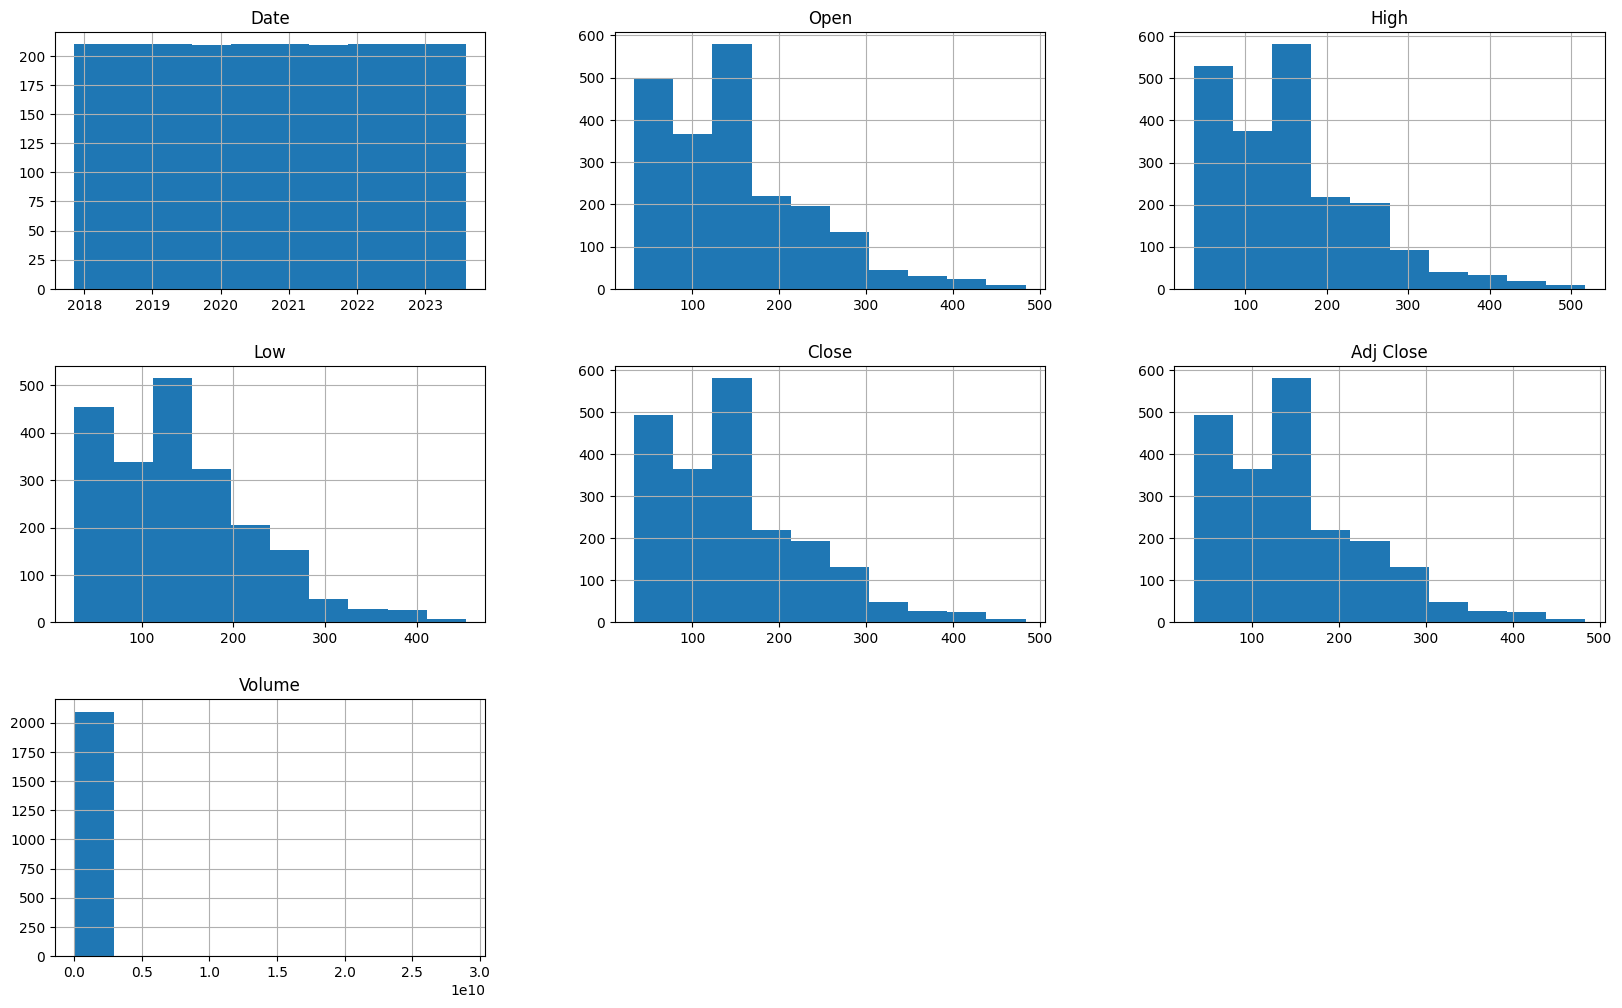

In [20]:
X_train.hist(figsize=[20, 12])
plt.show()

In [21]:
X_train.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2098.000000,2098.000000,2098.000000,2098.000000,2098.000000,2.098000e+03
mean,150.131070,155.617458,144.165698,150.118261,150.118261,2.490891e+08
std,82.855785,87.391499,77.687116,82.800364,82.800364,1.014184e+09
min,33.084614,36.645374,26.703888,33.010323,33.010323,1.016030e+07
25%,81.922337,83.849741,78.950661,81.971788,81.971788,6.545999e+07
50%,143.440933,146.920006,140.113480,143.457558,143.457558,1.045898e+08
75%,196.344128,203.160503,187.159626,196.357681,196.357681,1.930206e+08
max,483.709991,517.620239,453.390991,483.583618,483.583618,2.895912e+10


### Normalizing


##### method 1 : Standard Scaler


In [22]:
# def normalization(df: pd.DataFrame, method):

In [23]:
X_train_normalized_sc = X_train.copy()
X_validation_normalized_sc = X_validation.copy()

scaler = StandardScaler()
cols = X_train.drop(columns=["Date"]).columns
X_train_normalized_sc[cols] = scaler.fit_transform(X_train_normalized_sc[cols])
X_validation_normalized_sc[cols] = scaler.transform(X_validation_normalized_sc[cols])

In [24]:
X_train_normalized_sc.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2.098000e+03,2.098000e+03,2.098000e+03,2.098000e+03,2.098000e+03,2098.000000
mean,5.418820e-17,8.128230e-17,-8.128230e-17,-2.709410e-17,-2.709410e-17,0.000000
std,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00,1.000238e+00,1.000238
min,-1.412990e+00,-1.361694e+00,-1.512346e+00,-1.414678e+00,-1.414678e+00,-0.235643
25%,-8.234186e-01,-8.214166e-01,-8.396577e-01,-8.232176e-01,-8.232176e-01,-0.181104
50%,-8.076361e-02,-9.954660e-02,-5.217318e-02,-8.046210e-02,-8.046210e-02,-0.142512
75%,5.578859e-01,5.441534e-01,5.535561e-01,5.585778e-01,5.585778e-01,-0.055297
max,4.026978e+00,4.143299e+00,3.981342e+00,4.028302e+00,4.028302e+00,28.315257


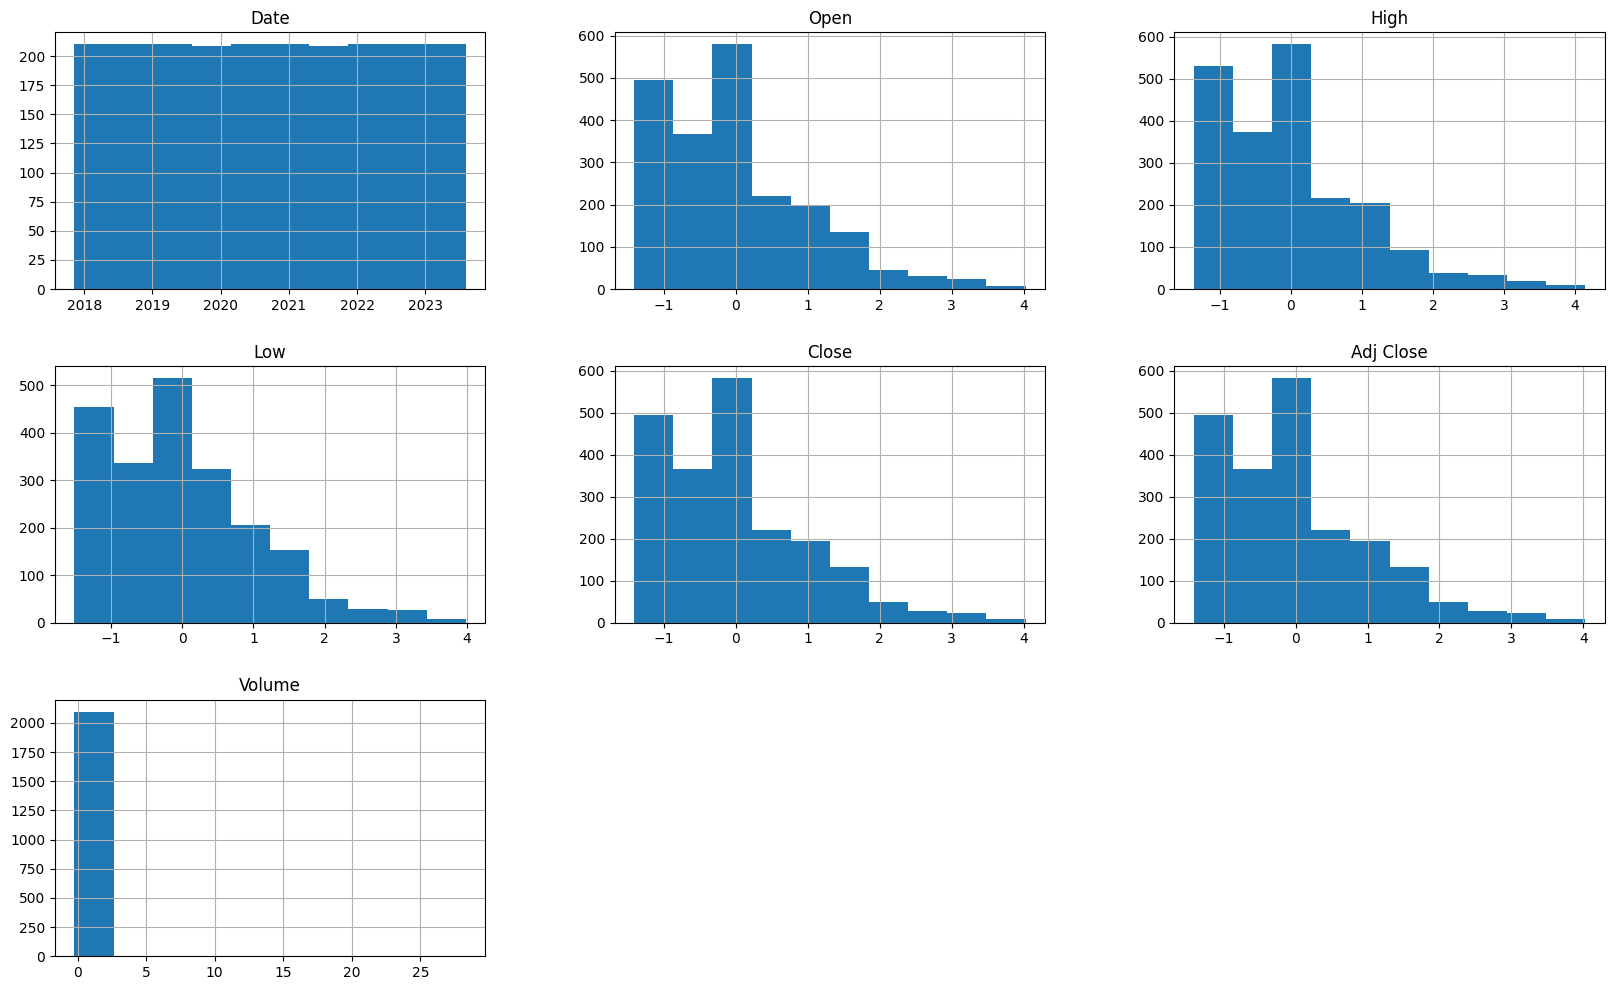

In [25]:
X_train_normalized_sc.hist(figsize=[20, 12])
plt.show()

##### method 2 : Power Transform


In [26]:
X_train_transformed = X_train.copy()
X_validation_transformed = X_validation.copy()

power_transformer = PowerTransformer(method="yeo-johnson", standardize=True)

cols = X_train.drop(columns=["Date"]).columns

X_train_transformed[cols] = power_transformer.fit_transform(X_train_transformed[cols])
X_validation_transformed[cols] = power_transformer.transform(
    X_validation_transformed[cols]
)

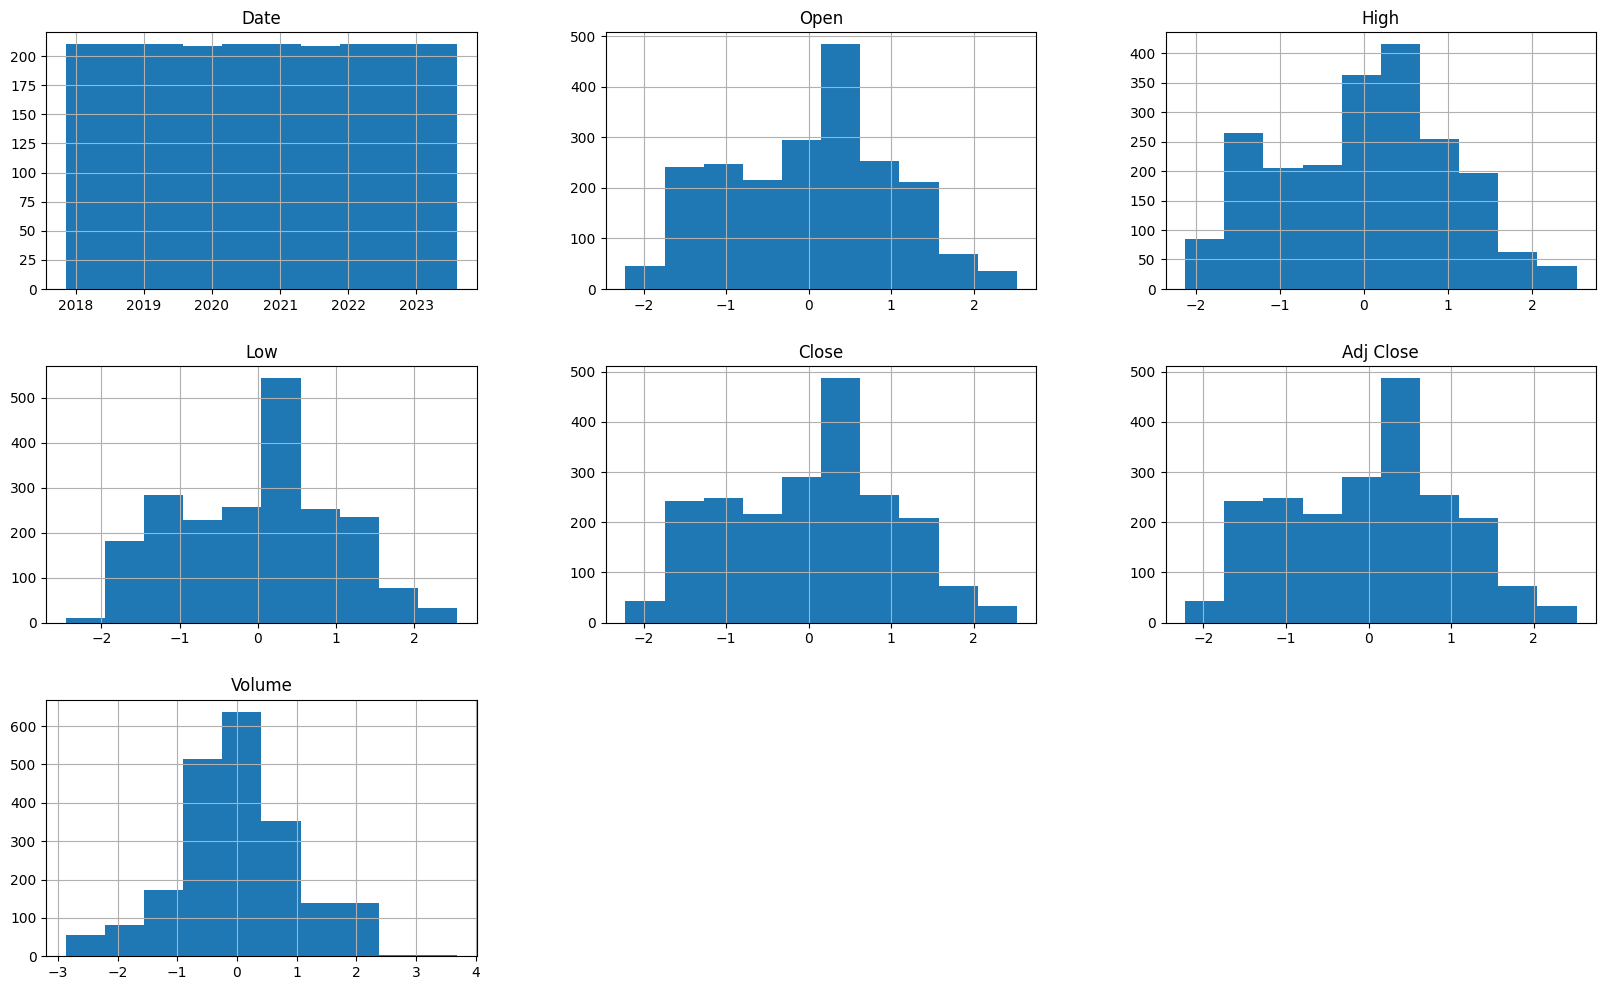

In [27]:
X_train_transformed.hist(figsize=[20, 12])
plt.show()

# Stock Chart Plot

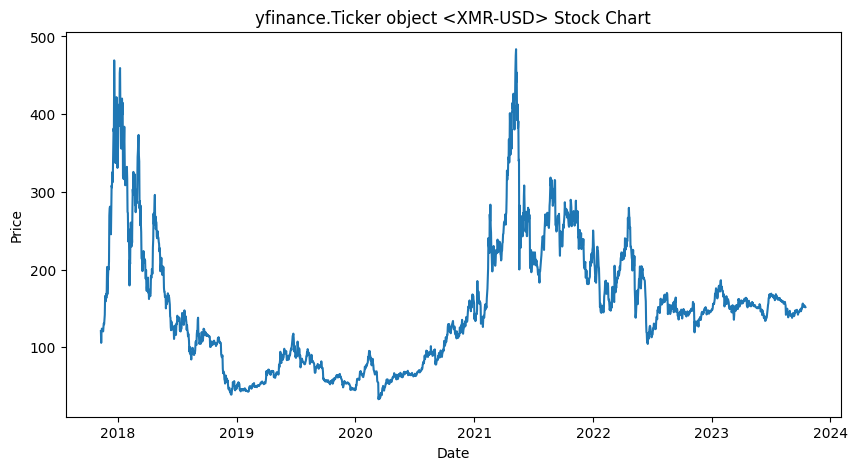

In [31]:
plt.figure(figsize=(10,5))
plt.plot(df_xmr['Close'])
plt.title(f"{xmr} Stock Chart")
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Canclestick Chart Plot

In [32]:
! pip install mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.4 MB/s eta 0:00:00


[*********************100%%**********************]  1 of 1 completed


/usr/local/lib/python3.10/dist-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


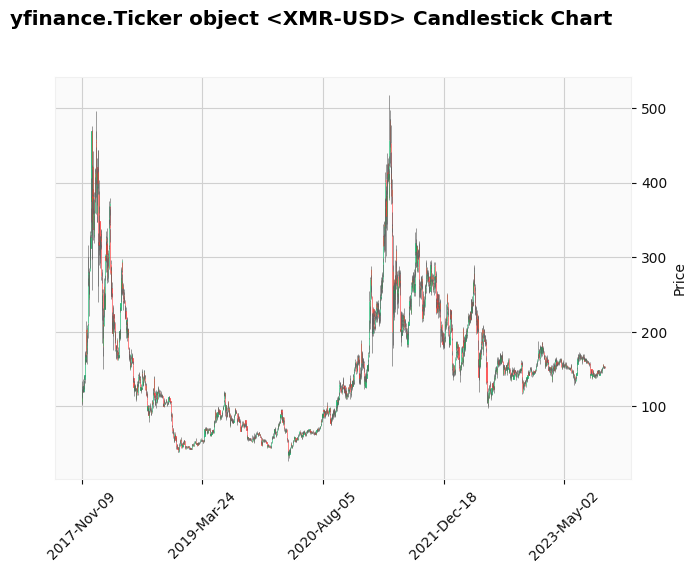

In [33]:
import mplfinance as mpf

xmr = yf.Ticker("XMR-USD")
# symbol = input()

# start_data = ''
# end_date = ''
# stock_data = yf.download(symbol, start=start_date, end=end_date)
df_xmr = yf.download(tickers="XMR-USD", period="max", interval="1d")

mpf.plot(df_xmr, type='candle', style='yahoo', title=f'{xmr} Candlestick Chart')